In [37]:
using RDatasets, StatsBase, Statistics, DataFrames
using Revise
using CairoMakie
CairoMakie.activate!()
Makie.inline!(true)
import JSON
includet("Utils.jl")
includet("FunctionData.jl")
data = JSON.parsefile("2023_results.json"); #intake data from json
full_race_points = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #points awarded for full length races
sprint_race_points = [8, 7, 6, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]; #points awarded for sprint (short) races

In [38]:
#collect all driver numbers used throughout the season
all_driver_nums = Utils.get_season_driver_nums(data)

race_df = DataFrame(Driver_Number=all_driver_nums)
for i in 1:length(data)
    race_name = data[i][1]
    race_data = data[i][2]
    positions = []
    ids = []
    missing_drivers = []
    for j in 1:length(race_data)
        #figure out which drivers did not participate in this race
        if data[i][2][20] != nothing
            numbers = map(d->d["driver_number"],data[i][2])
        else
            numbers = map(d->d["driver_number"],data[i][2][1:end-1])
        end
        missing_drivers = Utils.list_diff_multi(numbers, all_driver_nums)
        if race_data[j] != nothing
            push!(positions, race_data[j]["position"])
            push!(ids, race_data[j]["driver_number"])
            #race_df.Driver_Number
        end 
    end
    for k in 1:length(missing_drivers)
        push!(positions, missing)
        push!(ids, missing_drivers[k])
    end
    sub_df = DataFrame(Driver_Number=ids, Race_Name=positions)
    rename!(sub_df, ["Driver_Number", data[i][1]])
    race_df = innerjoin(race_df, sub_df, on="Driver_Number")
    #race_df[!, data[i][1]] = sub_df[!, 2]
end

sort!(race_df, "Sakhir:Race")

Row,Driver_Number,Sakhir:Race,Jeddah:Race,Melbourne:Race,Baku:Sprint,Baku:Race,Miami:Race,Monte Carlo:Race,Catalunya:Race,Montreal:Race,Spielberg:Sprint,Spielberg:Race,Silverstone:Race,Hungaroring:Race,Spa-Francorchamps:Sprint,Spa-Francorchamps:Race,Zandvoort:Race,Monza:Race,Singapore:Race,Suzuka:Race,Lusail:Sprint,Lusail:Race,Austin:Sprint,Austin:Race,Mexico City:Race,Interlagos:Sprint,Interlagos:Race,Las Vegas:Race,Yas Marina Circuit:Race
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,1,2,1,3,2,1,1,1,1,1,1,1,1,1,1,1,1,5,1,2,1,1,1,1,1,1,1,1
2,11,2,1,5,1,1,2,16,4,6,2,3,6,3,19,2,4,2,8,19,18,10,5,5,20,3,4,3,4
3,14,3,3,3,6,4,3,2,7,2,5,6,7,9,20,5,2,9,15,8,9,6,13,18,18,11,3,9,7
4,55,4,6,12,5,5,5,8,5,5,3,4,10,8,4,19,5,3,1,6,6,20,6,4,4,8,6,6,18
5,44,5,5,2,7,6,6,4,2,3,10,7,3,4,7,4,6,6,3,5,5,19,2,2,2,7,8,7,9
6,18,6,20,4,8,7,12,20,6,9,4,10,14,10,11,9,11,16,missing,18,13,11,20,9,17,12,5,5,10
7,63,7,4,18,4,8,4,5,3,19,8,8,5,6,8,6,17,5,16,7,4,4,8,7,6,4,15,8,3
8,77,8,18,11,16,18,13,11,19,10,20,16,12,12,13,12,15,10,17,20,11,8,16,14,14,19,16,17,19
9,10,9,9,13,13,14,8,7,10,12,15,9,18,20,3,11,3,15,6,10,10,12,7,8,11,13,7,11,13


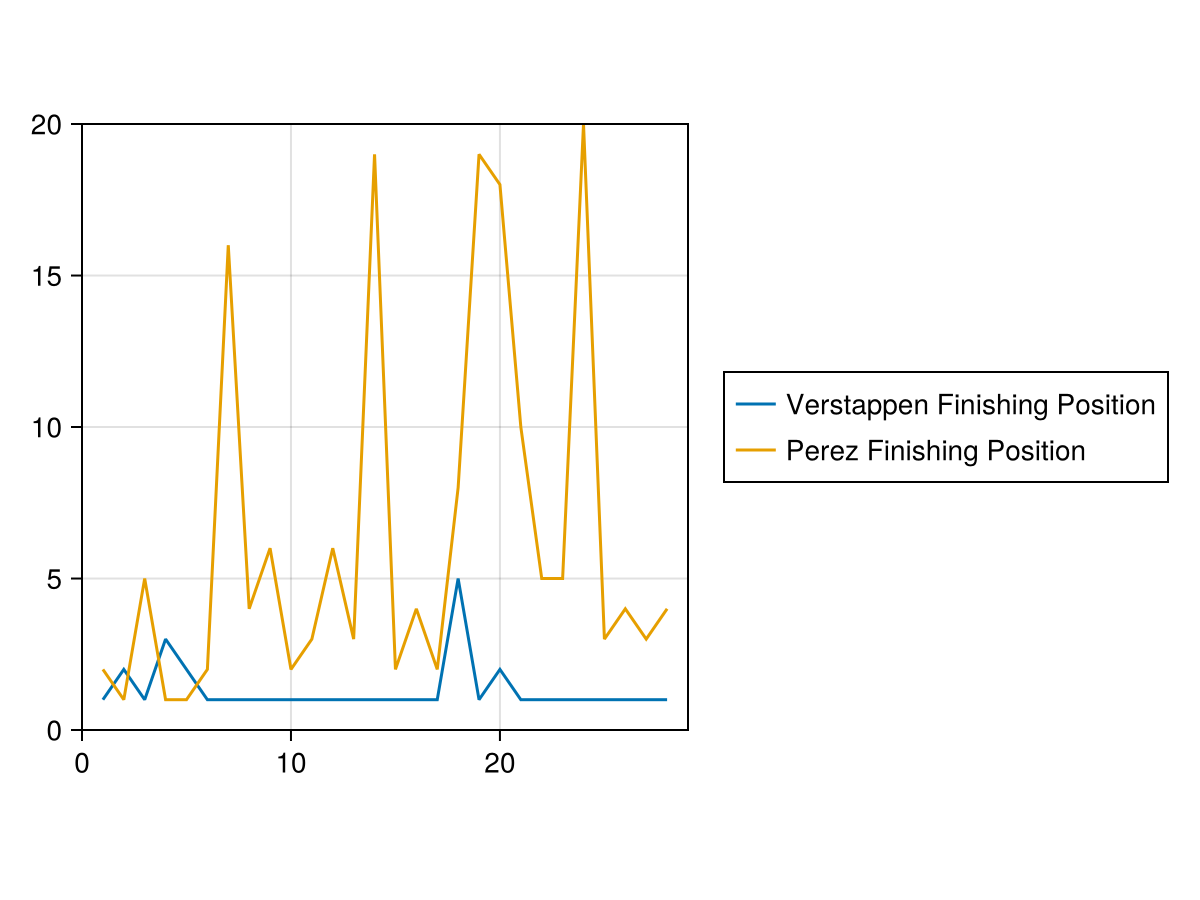

In [39]:
fig = Figure()
ax = Axis(fig[1,1], aspect = 1, limits = (0, 29, 0, 20))
ver = Array(race_df[1, :][2:end])
per = Array(race_df[2, :][2:end])
lines!(1:length(ver), ver, label="Verstappen Finishing Position")
lines!(1:length(per), per, label="Perez Finishing Position")
Legend(fig[1,2], ax)
fig

In [40]:
#filling in the missing data, anyone who did not contest a race is put in 21st place, only 20 cars enter the race.
cleaned_race_df = copy(race_df)
for i in 2:ncol(cleaned_race_df)
    race = cleaned_race_df[!, i]
    for j in 1:length(race)
        if (typeof(race[j]) == Missing)
            race[j] = 21
        end
    end
end

cleaned_race_df

Row,Driver_Number,Sakhir:Race,Jeddah:Race,Melbourne:Race,Baku:Sprint,Baku:Race,Miami:Race,Monte Carlo:Race,Catalunya:Race,Montreal:Race,Spielberg:Sprint,Spielberg:Race,Silverstone:Race,Hungaroring:Race,Spa-Francorchamps:Sprint,Spa-Francorchamps:Race,Zandvoort:Race,Monza:Race,Singapore:Race,Suzuka:Race,Lusail:Sprint,Lusail:Race,Austin:Sprint,Austin:Race,Mexico City:Race,Interlagos:Sprint,Interlagos:Race,Las Vegas:Race,Yas Marina Circuit:Race
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,1,2,1,3,2,1,1,1,1,1,1,1,1,1,1,1,1,5,1,2,1,1,1,1,1,1,1,1
2,11,2,1,5,1,1,2,16,4,6,2,3,6,3,19,2,4,2,8,19,18,10,5,5,20,3,4,3,4
3,14,3,3,3,6,4,3,2,7,2,5,6,7,9,20,5,2,9,15,8,9,6,13,18,18,11,3,9,7
4,55,4,6,12,5,5,5,8,5,5,3,4,10,8,4,19,5,3,1,6,6,20,6,4,4,8,6,6,18
5,44,5,5,2,7,6,6,4,2,3,10,7,3,4,7,4,6,6,3,5,5,19,2,2,2,7,8,7,9
6,18,6,20,4,8,7,12,20,6,9,4,10,14,10,11,9,11,16,21,18,13,11,20,9,17,12,5,5,10
7,63,7,4,18,4,8,4,5,3,19,8,8,5,6,8,6,17,5,16,7,4,4,8,7,6,4,15,8,3
8,77,8,18,11,16,18,13,11,19,10,20,16,12,12,13,12,15,10,17,20,11,8,16,14,14,19,16,17,19
9,10,9,9,13,13,14,8,7,10,12,15,9,18,20,3,11,3,15,6,10,10,12,7,8,11,13,7,11,13


In [41]:
points_df = copy(cleaned_race_df)
for i in 2:ncol(points_df)
    col = points_df[!, i]
    if split(names(cleaned_race_df)[i], ":")[2] == "Race"
        col = map(x->full_race_points[x], col)
    else
        col = map(x->sprint_race_points[x], col)
    end
    points_df[!, i] = col
end

In [42]:
points_df

Row,Driver_Number,Sakhir:Race,Jeddah:Race,Melbourne:Race,Baku:Sprint,Baku:Race,Miami:Race,Monte Carlo:Race,Catalunya:Race,Montreal:Race,Spielberg:Sprint,Spielberg:Race,Silverstone:Race,Hungaroring:Race,Spa-Francorchamps:Sprint,Spa-Francorchamps:Race,Zandvoort:Race,Monza:Race,Singapore:Race,Suzuka:Race,Lusail:Sprint,Lusail:Race,Austin:Sprint,Austin:Race,Mexico City:Race,Interlagos:Sprint,Interlagos:Race,Las Vegas:Race,Yas Marina Circuit:Race
,Any,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,25,18,25,6,18,25,25,25,25,8,25,25,25,8,25,25,25,10,25,7,25,8,25,25,8,25,25,25
2,11,18,25,10,8,25,18,0,12,8,7,15,8,15,0,18,12,18,4,0,0,1,4,10,0,6,12,15,12
3,14,15,15,15,3,12,15,18,6,18,4,8,6,2,0,10,18,2,0,4,0,8,0,0,0,0,15,2,6
4,55,12,8,0,4,10,10,4,10,10,6,12,1,4,5,0,10,15,25,8,3,0,3,12,12,1,8,8,0
5,44,10,10,18,2,8,8,12,18,15,0,6,15,12,2,12,8,8,15,10,4,0,7,18,18,2,4,6,2
6,18,8,0,12,1,6,0,0,8,2,5,1,0,1,0,2,0,0,0,0,0,0,0,2,0,0,10,10,1
7,63,6,12,0,5,4,12,10,15,0,1,4,10,8,1,8,0,10,0,6,5,12,1,6,8,5,0,4,15
8,77,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0
9,10,2,2,0,0,0,4,6,1,0,0,2,0,0,6,0,15,0,8,1,0,0,2,4,0,0,6,0,0


In [43]:
#creates a table of cumulative points
cul_points_df = points_df
for i in 3:ncol(cul_points_df)
    col = cul_points_df[!, i]
    col_prev = cul_points_df[!, i - 1]
    col = col.+col_prev
    points_df[!, i] = col
end

In [44]:
sort(cul_points_df, :"Yas Marina Circuit:Race", rev=true)

Row,Driver_Number,Sakhir:Race,Jeddah:Race,Melbourne:Race,Baku:Sprint,Baku:Race,Miami:Race,Monte Carlo:Race,Catalunya:Race,Montreal:Race,Spielberg:Sprint,Spielberg:Race,Silverstone:Race,Hungaroring:Race,Spa-Francorchamps:Sprint,Spa-Francorchamps:Race,Zandvoort:Race,Monza:Race,Singapore:Race,Suzuka:Race,Lusail:Sprint,Lusail:Race,Austin:Sprint,Austin:Race,Mexico City:Race,Interlagos:Sprint,Interlagos:Race,Las Vegas:Race,Yas Marina Circuit:Race
,Any,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,25,43,68,74,92,117,142,167,192,200,225,250,275,283,308,333,358,368,393,400,425,433,458,483,491,516,541,566
2,11,18,43,53,61,86,104,104,116,124,131,146,154,169,169,187,199,217,221,221,221,222,226,236,236,242,254,269,281
3,44,10,20,38,40,48,56,68,86,101,101,107,122,134,136,148,156,164,179,189,193,193,200,218,236,238,242,248,250
4,16,0,6,6,13,28,34,42,42,54,54,72,74,80,84,99,99,111,123,135,137,147,153,161,176,180,180,198,216
5,14,15,30,45,48,60,75,93,99,117,121,129,135,137,137,147,165,167,167,171,171,179,179,179,179,179,194,196,202
6,55,12,20,20,24,34,44,48,58,68,74,86,87,91,96,96,106,121,146,154,157,157,160,172,184,185,193,201,201
7,4,0,0,8,8,10,10,12,12,12,12,22,40,58,61,67,73,77,95,113,119,134,139,154,164,171,189,189,199
8,63,6,18,18,23,27,39,49,64,64,65,69,79,87,88,96,96,106,106,112,117,129,130,136,144,149,149,153,168
9,81,0,0,4,4,4,4,5,5,5,5,5,17,27,34,34,36,36,42,57,65,83,83,83,87,87,87,88,96


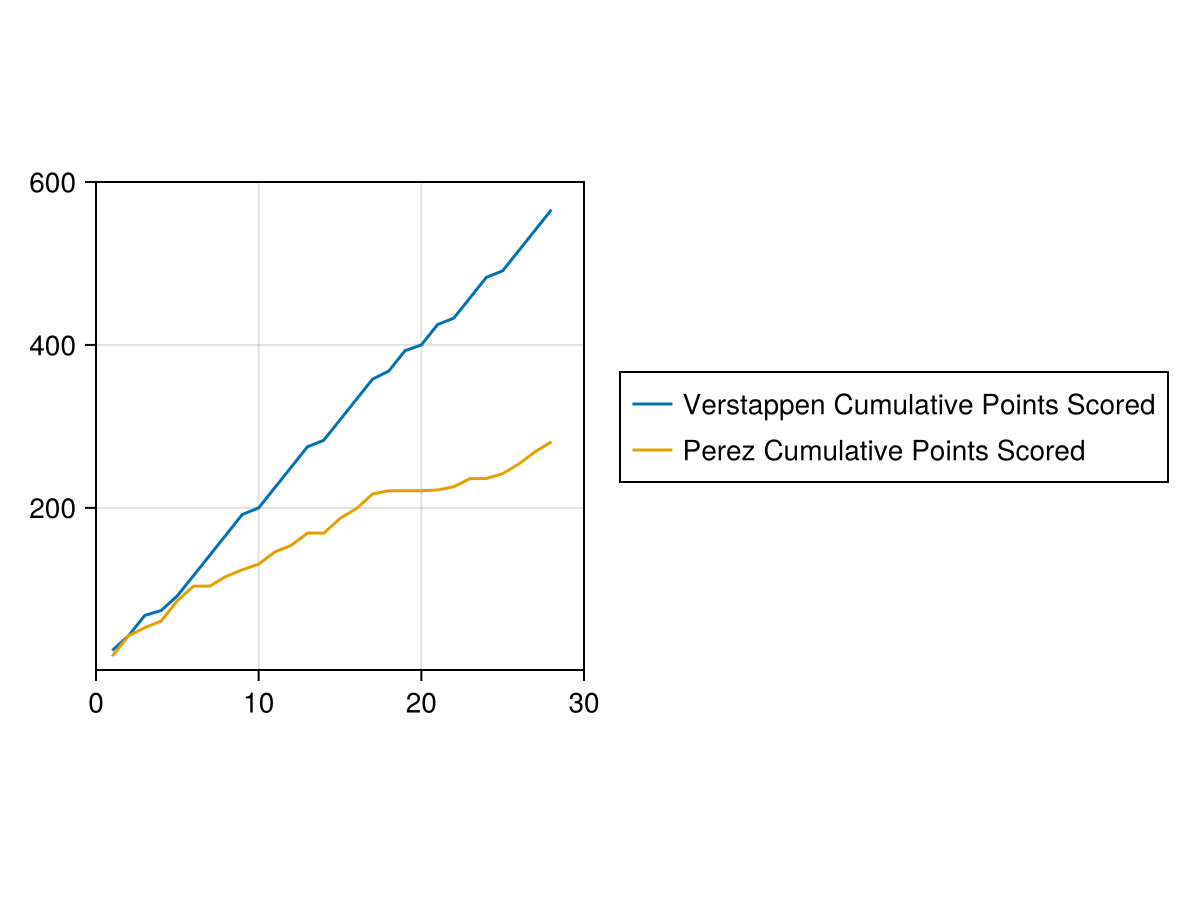

In [45]:
fig = Figure()
ax = Axis(fig[1,1], aspect = 1, limits = (0, 30, 1, 600))
ver = Array(cul_points_df[1, :][2:end])
per = Array(cul_points_df[2, :][2:end])
lines!(1:length(ver), ver, label="Verstappen Cumulative Points Scored")
lines!(1:length(ver), per, label="Perez Cumulative Points Scored")
Legend(fig[1,2], ax)
fig

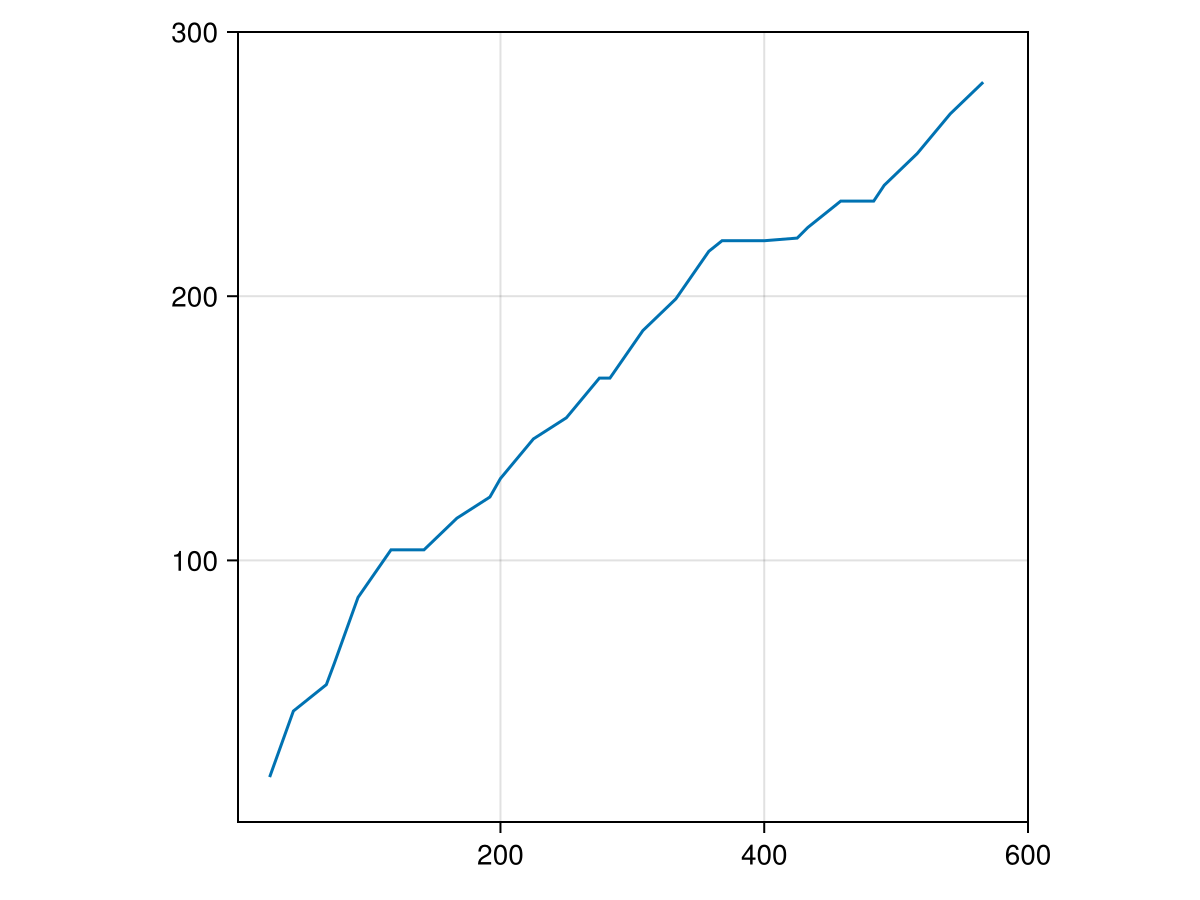

In [46]:
fig = Figure()
ax = Axis(fig[1,1], aspect = 1, limits = (1, 600, 1, 300))
ver = Array(cul_points_df[1, :][2:end])
per = Array(cul_points_df[2, :][2:end])
lines!(ver, per)
fig

In [52]:
dev = Array(race_df[14, :][2:end])
cleaned_dev = Utils.dropmissing(dev)
test = FunctionData.XYData(collect(1:length(cleaned_dev)), cleaned_dev)
a, b = FunctionData.linearRegression(test)
#now take a and b and apply them to the linear regression formula and graph

(0.04040404040404041, 15.404040404040403)

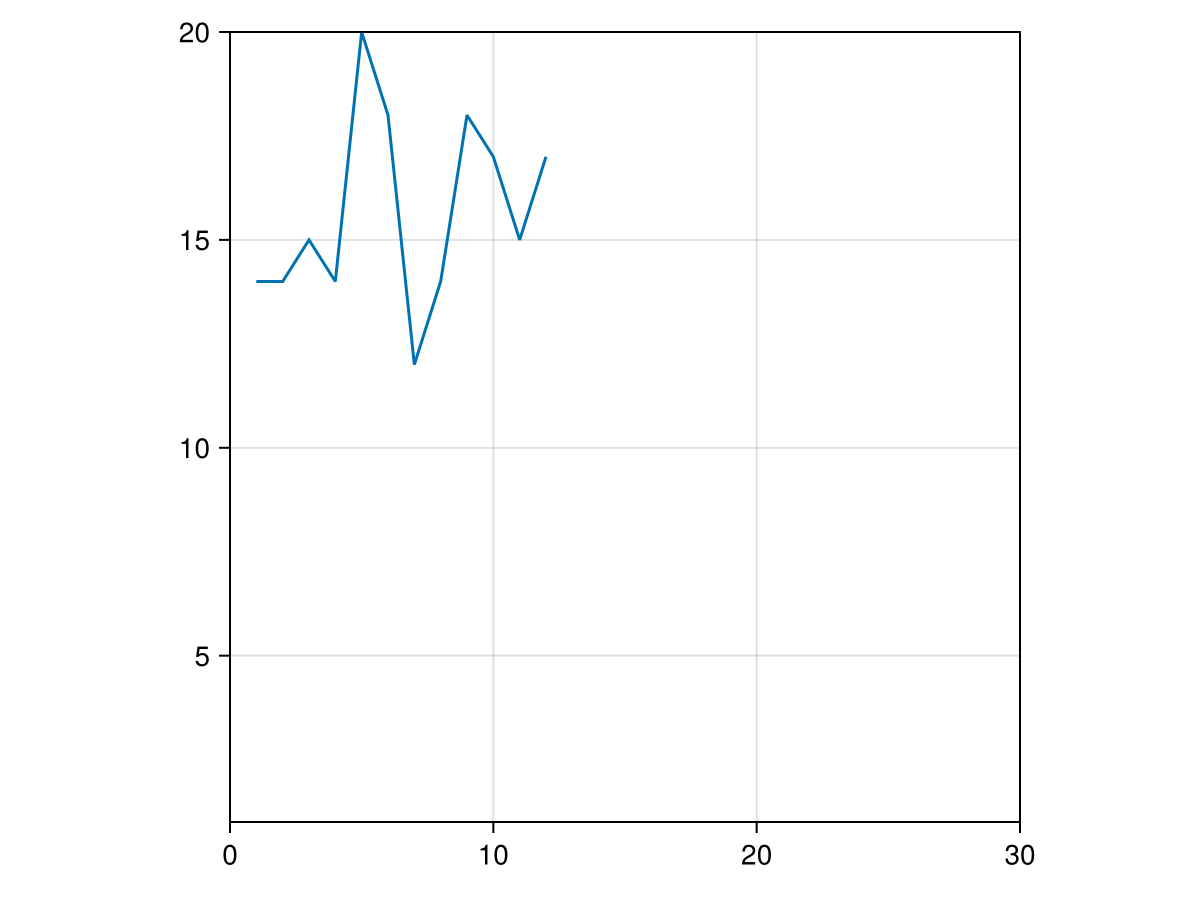

In [47]:
fig = Figure()
ax = Axis(fig[1,1], aspect = 1, limits = (0, 30, 1, 20))
dev = Array(race_df[14, :][2:end])
lines!(1:length(dev), dev)
fig